In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
from exp.nb_callbacks import *
from exp.nb_utils import listify
from exp.nb_metrics import Metric, AvgMetric

In [13]:
def make_metric(m):
    return m if isinstance(m, Metric) else AvgMetric(m)

In [95]:
#export
class Learner:
    _default_cbs = [TrainEvalCallback]

    ALL_CBS = {
    'begin_fit', 'begin_epoch', 'begin_batch', 'begin_validate',
    'after_pred', 'after_loss', 'after_backward', 'after_step',
    'after_batch', 'after_epoch', 'after_fit',
    'after_cancel_batch', 'after_cancel_epoch', 'after_cancel_train'}

    def __init__(self, model, data, loss_func, opt_func, lr=1e-2, metrics=None, cbs=None, cb_funcs=None):
        self.model, self.data, self.loss_func, self.opt_func, self.lr, self.metrics = model, data, loss_func, opt_func, lr, metrics

        self.opt = None
        self.cbs = []
        self.in_train = False
        self.logger = print

        self.add_cbs([cb() for cb in self._default_cbs])
        self.add_cbs(cbs)
        self.add_cbs([cbf() for cbf in listify(cb_funcs)])

    @property
    def metrics(self): return self._metrics
    @metrics.setter
    def metrics(self, metrics): 
        self._metrics = list(map(make_metric, metrics))

    def set_logger(self, logger):
        self.logger = logger

    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)

    def get_params(self):
        return self.model.parameters()

    def _do_begin_fit(self, epochs):
        self.epochs = epochs
        self.loss = tensor(0.)
        self('begin_fit')

    def _do_begin_epoch(self, epoch):
        self.epoch = epoch
        self.dl = self.data.train_dl
        return self('begin_epoch')

    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb, self.yb = xb, yb;                              self('begin_batch')
            self.pred = self.model(self.xb);                        self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb);         self('after_loss')
            # If validate
            if not self.in_train: return
            self.loss.backward();                                   self('after_backward')
            self.opt.step();                                        self('after_step')
            self.opt.zero_grad();
        except CancelBatchException:                                self('after_cancel_batch')
        finally:                                                    self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i, (xb, yb) in enumerate(self.dl):
                self.one_batch(i, xb, yb);
        except CancelEpochException: self('after_cancel_epoch')

    def _end_cleanup(self):
        self.dl, self.xb, self.yb, self.pred, self.loss = None, (None,), (None,), None, None

    def fit(self, epochs, cbs=None, reset_opt=False):
        self.add_cbs(cbs)
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.get_params(), lr=self.lr)

        try:
            self._do_begin_fit(epochs)
            for epoch in range(epochs):
                if not self._do_begin_epoch(epoch):
                    self.all_batches()
                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
        except CancelTrainException:                               self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
            self._end_cleanup()

    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) and res
        return res

In [96]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds[0][0].shape[0]
    print(data.train_ds[0][0].shape)
    model = nn.Sequential(nn.Conv2d(m,nh, 7, 2), nn.ReLU(),
                          nn.Conv2d(nh,nh*2, 5, 2), nn.ReLU(),
                          nn.Conv2d(nh*2,nh*2*2, 3, 2), nn.ReLU(),
                          nn.Conv2d(nh*4,nh*8, 3, 2), nn.ReLU(),
                          nn.AdaptiveAvgPool2d(1),
                          nn.Flatten(), nn.Linear(400,data.c))
    return model

In [97]:
from exp.nb_dataset import get_skin_databunch
db = get_skin_databunch(size=64*2)

In [98]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [99]:
from functools import partial

In [76]:
mdl = get_model(db)

torch.Size([3, 450, 600])


In [101]:
import torchvision.models as models
from torchvision import transforms as T

resnet18 = models.resnet18(pretrained=True)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
db = get_skin_databunch(size=None, transform=transform)

In [102]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 7)

In [103]:
learner = Learner(resnet18, db, F.cross_entropy, optim.Adam, metrics=[accuracy], cb_funcs=[Recorder, ProgressCallback])
learner.fit(10)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


KeyboardInterrupt: 

In [50]:
learner = Learner(mdl, db, F.cross_entropy, optim.Adam, cb_funcs=[partial(AvgStatsCallback,accuracy),Recorder, ProgressCallback])

TypeError: 'NoneType' object is not iterable

In [84]:
learner.fit(10)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.968716,0.500000,1256.333252,0.664062,00:33
1,31.723415,0.992188,6.444243,0.007812,00:31
2,3.334949,0.507812,1.594475,0.664062,00:30
3,1.097073,0.992188,1.984031,0.664062,00:30
4,0.074518,0.992188,496.174591,0.664062,00:30
5,9.326594,0.992188,113.130402,0.664062,00:31
6,1.179491,0.992188,19.916534,0.007812,00:30
7,1.479083,0.507812,27.773722,0.664062,00:31
8,0.164521,0.992188,4.861238,0.664062,00:31
9,0.069687,0.992188,7.558918,0.664062,00:31


['0', '0.968716', '0.500000', '1256.333252', '0.664062', '00:33']
['1', '31.723415', '0.992188', '6.444243', '0.007812', '00:31']
['2', '3.334949', '0.507812', '1.594475', '0.664062', '00:30']
['3', '1.097073', '0.992188', '1.984031', '0.664062', '00:30']
['4', '0.074518', '0.992188', '496.174591', '0.664062', '00:30']
['5', '9.326594', '0.992188', '113.130402', '0.664062', '00:31']
['6', '1.179491', '0.992188', '19.916534', '0.007812', '00:30']
['7', '1.479083', '0.507812', '27.773722', '0.664062', '00:31']
['8', '0.164521', '0.992188', '4.861238', '0.664062', '00:31']
['9', '0.069687', '0.992188', '7.558918', '0.664062', '00:31']


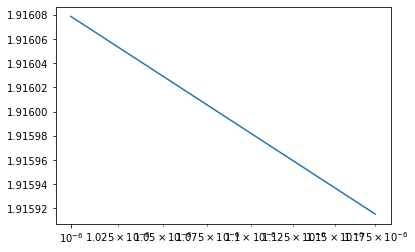

In [18]:
learner.recorder.plot()

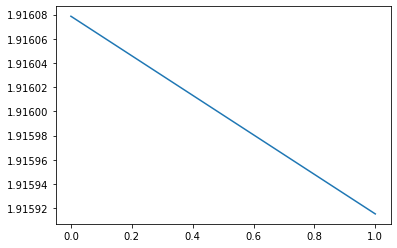

In [19]:
learner.recorder.plot_loss()

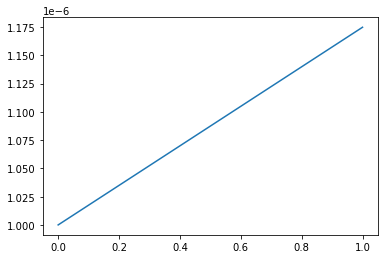

In [20]:
learner.recorder.plot_lr()

In [88]:
!python notebook2script.py learner.ipynb

Converted learner.ipynb to exp\nb_learner.py


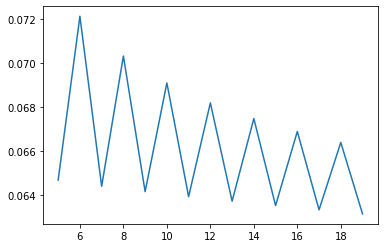

In [90]:
learner.recorder.plot_loss(with_valid=False)

In [91]:
learner.recorder.values

[[0.06565000861883163, 0.6640625, 2.1903767585754395, 0.6640625],
 [0.06505130231380463, 0.6640625, 2.213296890258789, 0.6640625],
 [0.06469689309597015, 0.6640625, 2.232323169708252, 0.6640625],
 [0.06441657245159149, 0.6640625, 2.248276710510254, 0.6640625],
 [0.06417249888181686, 0.6640625, 2.2617905139923096, 0.6640625],
 [0.06395000219345093, 0.6640625, 2.2733583450317383, 0.6640625],
 [0.06374165415763855, 0.6640625, 2.283360242843628, 0.6640625],
 [0.0635431557893753, 0.6640625, 2.2920992374420166, 0.6640625],
 [0.06335177272558212, 0.6640625, 2.299820899963379, 0.6640625],
 [0.06316570192575455, 0.6640625, 2.306722640991211, 0.6640625]]

In [93]:
idx = (np.array(learner.recorder.iters)<5).sum()
idx

2

In [94]:
learner.recorder.values[idx:]

[[0.06469689309597015, 0.6640625, 2.232323169708252, 0.6640625],
 [0.06441657245159149, 0.6640625, 2.248276710510254, 0.6640625],
 [0.06417249888181686, 0.6640625, 2.2617905139923096, 0.6640625],
 [0.06395000219345093, 0.6640625, 2.2733583450317383, 0.6640625],
 [0.06374165415763855, 0.6640625, 2.283360242843628, 0.6640625],
 [0.0635431557893753, 0.6640625, 2.2920992374420166, 0.6640625],
 [0.06335177272558212, 0.6640625, 2.299820899963379, 0.6640625],
 [0.06316570192575455, 0.6640625, 2.306722640991211, 0.6640625]]